In [114]:
import pandas as pd
import numpy as np
import time
import os, shutil
import skimage.transform
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, MaxPooling2D, Dense, BatchNormalization, Activation

In [124]:
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [17]:
csv = "movie-genre-from-its-poster/MovieGenre.csv"
movies = pd.read_csv(csv, encoding="ISO-8859-1",keep_default_na=True)

print('movies.shape = ', movies.shape)

movies = movies[movies.Genre.notnull() ]
movies = movies[movies.Poster.notnull()]
movies = movies.reset_index(drop=True)
print('movies.shape after filtering = ', movies.shape)
movies.head()

movies.shape =  (40108, 6)
movies.shape after filtering =  (39263, 6)


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [3]:
movies.Poster[0]

'https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg'

In [4]:
#find unique genres
genres = movies.Genre.str.split("|") ##pandas series
unique_genres = []
for lst in genres:
    for e in lst:
        if e not in unique_genres:
            unique_genres.append(e)
print('Unique Genres: \n',unique_genres)
print('\n Length of Unique Genres: \n', len(unique_genres))

# genres count 
from collections import Counter
genres = [item for lst in genres for item in lst]
genres_count =  dict(Counter(genres))
print('\n', 'Genres Counter: \n',genres_count)

Unique Genres: 
 ['Animation', 'Adventure', 'Comedy', 'Action', 'Family', 'Romance', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Horror', 'Biography', 'History', 'Mystery', 'Sci-Fi', 'War', 'Sport', 'Music', 'Documentary', 'Musical', 'Western', 'Short', 'Film-Noir', 'Talk-Show', 'News', 'Adult', 'Reality-TV', 'Game-Show']

 Length of Unique Genres: 
 28

 Genres Counter: 
 {'Animation': 1704, 'Adventure': 3807, 'Comedy': 12565, 'Action': 5310, 'Family': 2084, 'Romance': 6189, 'Drama': 19856, 'Crime': 5249, 'Thriller': 4799, 'Fantasy': 2005, 'Horror': 3983, 'Biography': 1973, 'History': 1403, 'Mystery': 2388, 'Sci-Fi': 2002, 'War': 1162, 'Sport': 698, 'Music': 1270, 'Documentary': 3561, 'Musical': 837, 'Western': 846, 'Short': 920, 'Film-Noir': 403, 'Talk-Show': 6, 'News': 80, 'Adult': 9, 'Reality-TV': 2, 'Game-Show': 1}


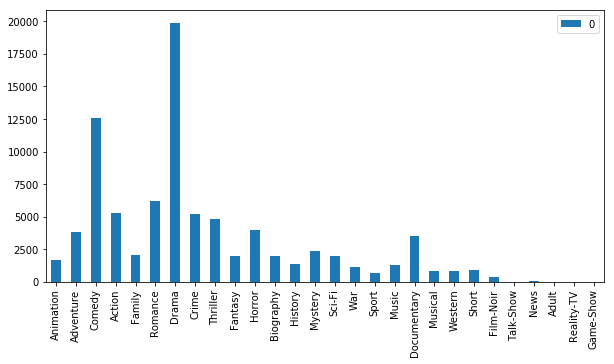

In [5]:
pd.DataFrame.from_dict(genres_count,orient='index').plot.bar(figsize=(10,5))

In [15]:
full_list = glob.glob('movie-genre-from-its-poster/SampleMoviePosters/*.jpg')
image_ids = []
for f in full_list:
    s = int(f.split('/')[-1][:-4])
    image_ids.append(s)

In [54]:
y = []
classes = tuple()
for image_id in image_ids:
    genres = tuple((movies[movies["imdbId"] == int(image_id)]["Genre"].values[0]).split("|"))
    y.append(genres)
    classes = classes + genres

In [82]:
x = []
for file in full_list:
    s = int(file.split('/')[-1][:-4])
    if s in movies["imdbId"]:
        img_array = io.imread(file,as_grey = True)
        img_array_resized = resize(img_array,(128,128))
        x.append(img_array_resized)
        genres = tuple((movies["Genre"].values[0]).split("|"))
        classes = classes + genres

/home/sabu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [83]:
X = np.asarray(x)
Y = np.asarray(y)

In [123]:
mlb = MultiLabelBinarizer()
mlb.fit(y)
Y = mlb.transform(Y)

In [128]:
classes = set(classes)
len(classes)

23

In [129]:
X = X.reshape(-1,128,128,1)

In [130]:
X = X/255

In [131]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.1,random_state = 0)

In [135]:
model = Sequential()
model.add(Conv2D(64,(3,3),input_shape = (128,128,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))   
model.add(Flatten())
model.add(Dense(23))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 64)      640       
_________________________________________________________________
activation_15 (Activation)   (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
__________

In [136]:
model.fit(X_train,Y_train, epochs=5, validation_split=0.1,batch_size=32)

Train on 807 samples, validate on 90 samples
Epoch 1/5
807/807 [==============================] - 69s 85ms/step - loss: 5.7784 - acc: 0.3432 - val_loss: 5.4730 - val_acc: 0.4000
Epoch 2/5
384/807 [=============>................] - ETA: 19s - loss: 5.3894 - acc: 0.3464

KeyboardInterrupt: 